In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
import cartopy.feature as cf
import shapely.geometry as sgeom
from matplotlib.patches import Rectangle
from scipy.signal import detrend

In [2]:
def load_data(member):
    """"Load the data from the directory for different member number  
    """
    # Load temperature and sea surface temperature data
    tas_path = f"/work/uo1075/u301680/all_member/land/europe_{member}_land.nc"
    tos_path = f"/work/uo1075/u301680/all_member/ocean/member_{member}_tos_regrid.nc"

    all_tas = xr.open_dataset(tas_path).sel(time=slice("1960", "2014"))
    all_tos = xr.open_dataset(tos_path).sel(time=slice("1960", "2014"))
    
    return all_tas, all_tos


def subset_data(all_tas, all_tos):
    """Selct Europe and North Atlantic region
    """
    sat_subset = all_tas.sel(lat=slice(30, 80), lon=slice(-30, 40))
    sst_subset = all_tos.sel(lat=slice(0, 70), lon=slice(265, 355))
    
    return sat_subset, sst_subset


def Calculate_seasonal_mean(sat_subset, sst_subset):
    """"Calculate seasonal mean 
    """
    seasonal_sat = sat_subset['tas'].resample(time="QS-DEC").mean()
    winter_sat = seasonal_sat.sel(time=seasonal_sat.time.dt.month==12)[1:]

    seasonal_sst = sst_subset['tos'].resample(time="QS-DEC").mean()
    autumn_sst = seasonal_sst.sel(time=seasonal_sst.time.dt.month==9)
    # autumn_sst = autumn_sst.fillna(autumn_sst.mean())
    
    return winter_sat, autumn_sst


def calculate_area_average(winter_sat, autumn_sst):
    """Calculate the spatial average
    """
    winter_sat_values = np.nanmean(winter_sat, axis=(1, 2))
    autumn_sst_values = np.nanmean(autumn_sst, axis=(1, 2)) 
    
    return winter_sat_values, autumn_sst_values

In [3]:
def correlation_over_EU(winter_sat, autumn_sst_values):
    """Calculate correlation values over EU
    """
    corr_EU = np.empty((len(winter_sat['lat']), len(winter_sat['lon'])))

    for i, lat in enumerate(winter_sat['lat']):
        for j, lon in enumerate(winter_sat['lon']):
            value = winter_sat.sel(lat=lat, lon=lon)
            correlation = np.corrcoef(autumn_sst_values, value)[0, 1]
            corr_EU[i, j] = correlation
    return corr_EU

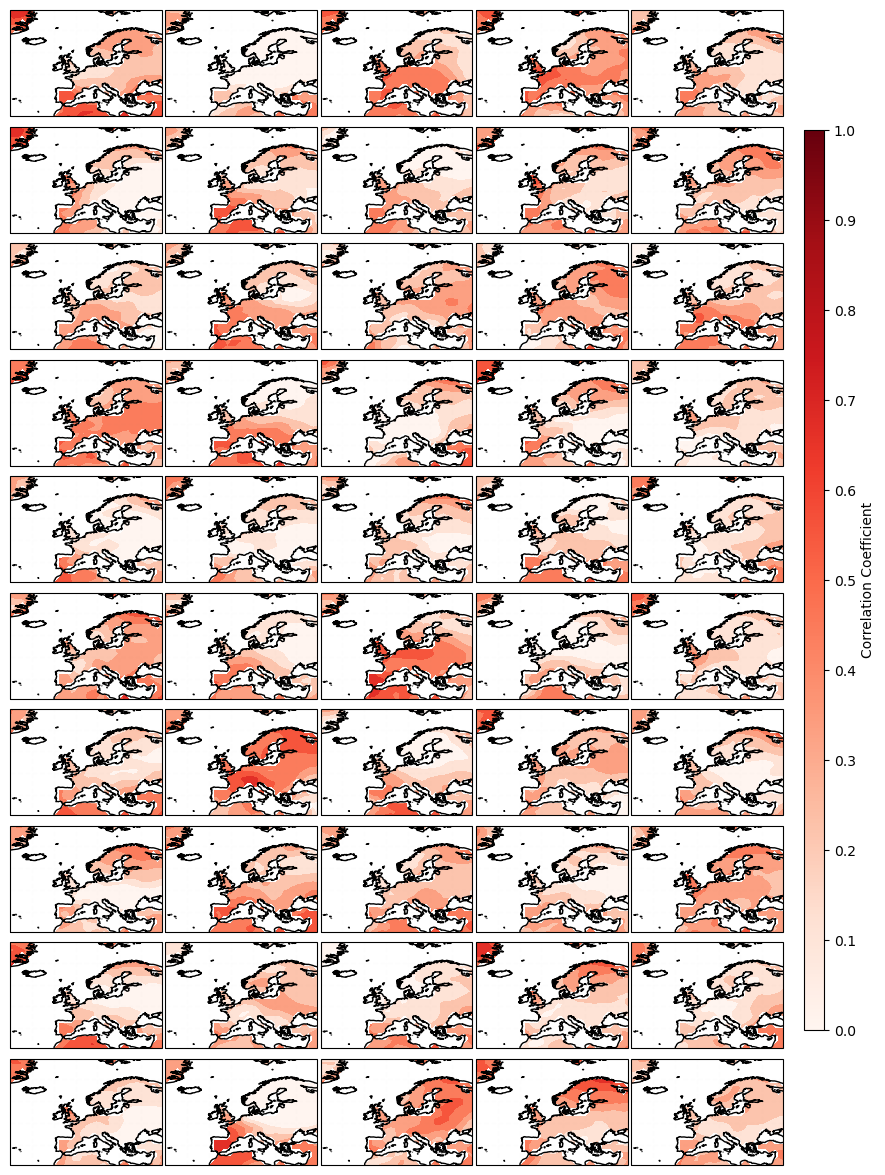

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colorbar import ColorbarBase

# Set the number of rows and columns
num_rows = 10
num_columns = 5

# Create a figure and axes for subplots with a PlateCarree projection
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()

# Set contour levels, color, and color levels
contour_levels = np.arange(0, 1.1, 0.1)
single_color = 'darkred'
num_levels = 10 
colors = [plt.cm.Reds(i / (num_levels - 1)) for i in range(num_levels)]

# Create a colorbar axis (cax) outside of the subplots
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Adjust position and size as needed

# Iterate over member numbers from 1 to 50
for member in range(1, 51):
    # Load data for the current member
    all_tas, all_tos = load_data(member)
    
    # Subset the data for Europe and North Atlantic
    sat_subset, sst_subset = subset_data(all_tas, all_tos)

    # Calculate seasonal mean for land temperature and sea surface temperature
    winter_sat, autumn_sst = Calculate_seasonal_mean(sat_subset, sst_subset)

    # Calculate area averages for winter land temperature and autumn sea surface temperature
    winter_sat_values, autumn_sst_values = calculate_area_average(winter_sat, autumn_sst)

    # Calculate correlation over EU region
    corr_EU = correlation_over_EU(winter_sat, autumn_sst_values)

    # Get the current subplot
    ax = axes[member - 1]

    # Plot the correlation values over the North Atlantic region on the current subplot
    c = ax.contourf(winter_sat['lon'], winter_sat['lat'], corr_EU, colors=colors, transform=ccrs.PlateCarree(), 
                    extend='both', levels=contour_levels) 

    # Add gridlines and labels to the map
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.01, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.coastlines()

# Create a single colorbar for all subplots
cb = ColorbarBase(cax, cmap=plt.cm.Reds, ticks=contour_levels, label='Correlation Coefficient')
plt.subplots_adjust(wspace=0.01, hspace=0.1)  # Adjust the values as needed

# Adjust layout and show the plots
# plt.tight_layout()
plt.savefig("correlation two")
# plt.title("Correlation Over North Atlnatic")
plt.show()